In [9]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import queue
from sklearn.neighbors import NearestNeighbors

In [10]:
def loadAllData(path):
    """
    Load all the volatility for all day in a numpy array
    Use for the PCA
    """
    #loading data (pickle file)
    unpickled_df = pd.read_pickle(path)
    Ndays = len(unpickled_df)
    data = np.empty((Ndays,441))
    j = 0
    maturities = [5,13,36,58,80,110,140,200,300,400,500,800,900,1150,1400,1550,2000,2450,2700,2900,3200]
    myrow = [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]

    for df in unpickled_df:
        
        df.set_index(['nBizDays'], inplace = True)
            
        
        #Add rows in df for maturity that we want
        for i in maturities:
            exitingIndex = i in df.index
            if exitingIndex == False :
                
                df.loc[i] = myrow
        df.sort_index(inplace = True)

        #interpolation
        for col in df:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        
        df.interpolate(method = "values", limit_direction = "both", inplace = True)
        
        #Fill allData in 1 np.array
        df.drop(columns=['Forwards', 'nCalDays', 'diff Days'], inplace = True)
        df = df.loc[maturities,:]
        Nrows = len(df)
        Ncolumns = len(df.columns)
        data[j] = np.array(df.iloc[:,:], dtype = np.float).reshape(-1)
        j = j + 1
    return data

In [11]:
data = loadAllData("NKY_clean.pkl")

In [12]:
def PCA(X:np.ndarray):
    #Standardize data  
    X_scaled = (X - np.mean(X , axis = 0))/np.std(X)

    # calculating the covariance matrix of the mean-centered data.
    cov_mat = np.cov(X_scaled , rowvar = False)

    #Calculating Eigenvalues and Eigenvectors of the covariance matrix
    #Eigen Values is 1D array and Eigen Vectors is ndarray
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    eigen_values = np.real(eigen_values)
    
    #sort the eigen values and eigen vectors in descending order
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    
    # Calculating the explained variance on each of components
    variance_explained = []
    for i in sorted_eigenvalue:
        variance_explained.append((i/sum(sorted_eigenvalue))*100)
    # Cumulative explained variance
    cumulative_variance_explained = np.cumsum(variance_explained)
    # Visualizing the eigenvalues
    sns.lineplot(x = np.arange(24), y=cumulative_variance_explained[0:24])
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.title("Explained variance vs Number of components")
    plt.show()

    #Projection Matrix
    n_components = 5
    projection_matrix = (eigen_vectors.T[:][:n_components]).T
    X_pca = np.dot(X_scaled, projection_matrix)
    
    if n_components == 2 :
        #Visualizing the new coordinates
        df = pd.DataFrame(data = X_pca, columns = ('first principal component', 'second principal component') )
        print(df)
        sns.FacetGrid(df).map(plt.scatter,'first principal component', 'second principal component')
        plt.show()
    return X_pca

In [13]:
class LeafNode:
    def __init__(self, size, data):
        self.size = size
        self.data = data


class DecisionNode:
    def __init__(self, left, right, splitFeature, splitValue):
        self.left = left
        self.right = right
        self.splitFeature = splitFeature
        self.splitValue = splitValue


class IsolationTree:
    def __init__(self, height, maxDepth):
        self.height = height
        self.maxDepth = maxDepth

    def fit(self, X):
        """
        Given a 2D matrix of observations, create an isolation tree. Set field
        self.root to the root of that tree and return it.
        """
        if self.height >= self.maxDepth or X.shape[0] <= 2: #X.shapes[0] number of points
            self.root = LeafNode(X.shape[0], X)
            return self.root

        # Choose Random Split features and Value
        num_features = X.shape[1] #X.shapes[1] number of features
        splitFeature = np.random.randint(0, num_features) #take radomly a feature
        splitValue = np.random.uniform(min(X[:, splitFeature]), max(X[:, splitFeature])) #take randomly a value

        X_left = X[X[:, splitFeature] < splitValue]
        X_right = X[X[:, splitFeature] >= splitValue]

        leftTree = IsolationTree(self.height + 1, self.maxDepth)
        rightTree = IsolationTree(self.height + 1, self.maxDepth)
        leftTree.fit(X_left)
        rightTree.fit(X_right)
        self.root = DecisionNode(leftTree.root, rightTree.root, splitFeature, splitValue)
        self.n_nodes = self.count_nodes(self.root)
        return self.root

    def count_nodes(self, root):
        count = 0
        stack = [root]
        while stack:
            node = stack.pop()
            count += 1
            if isinstance(node, DecisionNode):
                stack.append(node.right)
                stack.append(node.left)
        return count
    
class IsolationForest:
    def __init__(self, sample_size, n_trees=10):
        self.sample_size = sample_size
        self.n_trees = n_trees

    def fit(self, X): #X must be ndarray
        """
        Given a 2D matrix of observations, create an ensemble of IsolationTree
        objects and store them in a list: self.trees.  Convert DataFrames to
        ndarray objects.
        """
        self.trees = [] #array of n treess
        if isinstance(X, pd.DataFrame):
            X = X.values
        n_rows = X.shape[0]
        height_limit = np.ceil(np.log2(self.sample_size))
        for i in range(self.n_trees):
            data_index = np.random.choice(range(n_rows), size=self.sample_size, replace=False).astype(int)
            #We are using the bootstrap in order to create new Sub_data
            #choose randomly the sample (size = sample_size) from the dataSet wich we are going to apply isolation forest 
            #data_index = np.random.randint(0, n_rows, self.sample_size) 
            X_sub = X[data_index]
            tree = IsolationTree(0, height_limit)
            tree.fit(X_sub)
            self.trees.append(tree)
        return self

    def path_length(self, X:np.ndarray) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the average path length
        for each observation in X, we compute the path length for x_i using every
        tree in self.trees then compute the average for each x_i.  
        Return an ndarray of shape (len(X),1).
        """
        paths = []
        for row in X:
            path = []
            for tree in self.trees:
                node = tree.root
                length = 0
                while isinstance(node, DecisionNode):
                    if row[node.splitFeature] < node.splitValue:
                        node = node.left
                    else:
                        node = node.right
                    length += 1
                leaf_size = node.size
                pathLength = length + c(leaf_size)
                path.append(pathLength)
            paths.append(path)
        paths = np.array(paths)
        return np.mean(paths, axis=1)

    def anomaly_score(self, X:pd.DataFrame) -> np.ndarray:
        """
        Given a 2D matrix of observations, X, compute the anomaly score
        for each x_i observation, returning an ndarray of them.
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        avg_length = self.path_length(X)
        scores = np.array([np.power(2, -l/c(self.sample_size))for l in avg_length])
        return scores

    def predict_from_anomaly_scores(self, scores:np.ndarray, threshold:float) -> np.ndarray:
        """
        Given an array of scores and a score threshold, return an array of
        the predictions: 1 for any score >= the threshold and 0 otherwise.
        """
        return np.array([1 if s >= threshold else 0 for s in scores])

    def predict(self, X:np.ndarray, threshold:float) -> np.ndarray:
        "A shorthand for calling anomaly_score() and predict_from_anomaly_scores()."
        scores = self.anomaly_score(X)
        prediction = self.predict_from_anomaly_scores(scores, threshold)
        return prediction    
    
def c(size):
    if size > 2:
        return 2 * (np.log(size-1)+0.5772156649) - 2*(size-1)/size
    if size == 2:
        return 1
    return 0

def pltData(data, label):
    fig = plt.figure()
    #ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(data[:,0], data[:,1],data[:,2], c = label)
    l = ["green" if elt == 0 else "red" for elt in label]
    plt.scatter(data[:,0], data[:,1],c=l, alpha=1, marker='.', s = 120) 
    plt.xlabel("First Principal Component")      
    plt.ylabel("Second Principal Component")     
    plt.show()

def outliersDays(label):
    outliers = []
    for i in range(len(label)):
        if label[i] == 1:
            outliers.append(i)
    return outliers



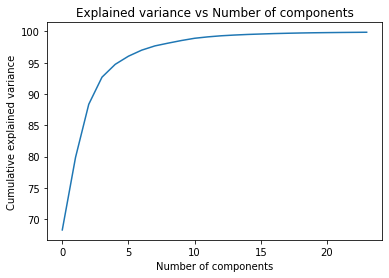

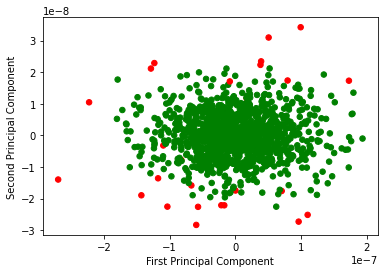

[2, 3, 6, 7, 11, 20, 31, 32, 37, 43, 54, 63, 65, 69, 72, 80, 85, 87, 91, 105, 273, 275, 422, 1143, 1213, 1220, 1252, 1273, 1276]


In [15]:
data_pca = PCA(data)
forest = IsolationForest(data_pca.shape[0], 100)
forest.fit(data_pca)
forest.path_length(data_pca)
threshold = 0.58
prediction = forest.predict(data_pca, threshold)
pltData(data_pca, prediction)
print(outliersDays(prediction))

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import collections
import queue
from sklearn.neighbors import NearestNeighbors


class DBSCAN:
    
    def __init__(self, data, radius, MinPt):
        self.data = data
        self.radius = radius
        self.MinPt = MinPt
        self.noise = 0
        self.unassigned = 0
        self.core=-1
        self.edge=-2
        
    #function to find all neigbor points in radius
    def neighbor_points(self, pointId):
        points = []
        for i in range(len(self.data)):
            #Euclidian distance using L2 Norm
            if sum((self.data[i] - self.data[pointId])**2) <= self.radius**2:
                points.append(i)
        return points
   
    
    def dbscan(self):
        #initilize all pointlabel to unassign
        pointlabel  = [self.unassigned] * len(self.data)
        pointcount = []
        #initialize list for core/noncore point
        corepoint=[]
        noncore=[]    
        
        #Find all neigbor for all point
        for i in range(len(self.data)):
            pointcount.append(DBSCAN.neighbor_points(self, i))
    
        #Find all core point, edgepoint and noise
        for i in range(len(pointcount)):
            if (len(pointcount[i])>=self.MinPt):
                pointlabel[i]=self.core
                corepoint.append(i)
            else:
                noncore.append(i)    
                
        for i in noncore:
            for j in pointcount[i]:
                if j in corepoint:
                    pointlabel[i]=self.edge
                    break
                
        #start assigning point to luster
        cl = 1
        #Using a Queue to put all neigbor core point in queue and find neigboir's neigbor
        for i in range(len(pointlabel)):
            q = queue.Queue()
            if (pointlabel[i] == self.core):
                pointlabel[i] = cl
                for x in pointcount[i]:
                    if(pointlabel[x]==self.core):
                        q.put(x)
                        pointlabel[x]=cl
                    elif(pointlabel[x]==self.edge):
                        pointlabel[x]=cl
                #Stop when all point in Queue has been checked   
                while not q.empty():
                    neighbors = pointcount[q.get()]
                    for y in neighbors:
                        if (pointlabel[y]==self.core):
                            pointlabel[y]=cl
                            q.put(y)
                        if (pointlabel[y]==self.edge):
                            pointlabel[y]=cl            
                cl=cl+1 #move to next cluster
                
        return pointlabel,cl
    
    #Function to plot final result with different clusters and anomalies
    def plotRes(self, clusterRes, clusterNum):
        nPoints = len(self.data)
        scatterColors = ['black', 'green', 'brown', 'red', 'purple', 'orange', 'yellow']
        for i in range(clusterNum):
            if (i==0):
                #Plot all noise point as blue
                color='blue'
            else:
                color = scatterColors[i % len(scatterColors)]
            abscissa = []
            ordinate = []
            for j in range(nPoints):
                if clusterRes[j] == i:
                    abscissa.append(self.data[j, 0])
                    ordinate.append(self.data[j, 1])
            plt.scatter(abscissa, ordinate, c=color, alpha=1, marker='.', s = 120)

    def plotRes3D(self, clusterNum):
        #plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatterColors = ['black', 'green', 'brown', 'red', 'purple', 'orange', 'yellow']
        for i in range(clusterNum):
            if (i==0):
                #Plot all noise point as blue
                color='red'
            else:
                color = scatterColors[i % len(scatterColors)]
            ax.scatter(self.data[:,0], self.data[:,1], self.data[:,2], c = color)
        plt.show()

def days_outliers(data):
        res = []
        for i in range(len(data)):
            if data[i]==0:
                res.append(i)
        return res

def Distances(data):
    distance=[]
    for i in range(len(data)):
        distance1=0
        for j in range(len(data)):
            if i!= j:
                distance1 += np.linalg.norm(data[i] - data[j])
        distance.append(distance)
    return distance

Set radius = 1.5141588684253164, Minpoints = 20


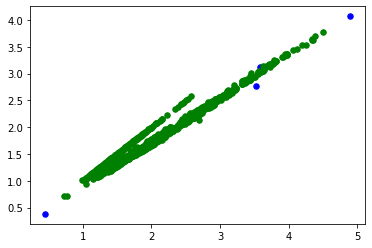

Number of clusters found: 1
Counter({1: 1292, 0: 4})
Numbrer of outliers found: 4



In [17]:
k = 10
NN = NearestNeighbors(n_neighbors = k).fit(data)
distances, indices = NN.kneighbors(data)
distanceSorted = sorted(distances[:,k-1], reverse = True)
radiusArray = np.percentile(distanceSorted,99)
clustering = DBSCAN(data, radiusArray, 20)
print('Set radius = ' +str(clustering.radius)+ ', Minpoints = '+str(clustering.MinPt))
pointlabel, cluster = clustering.dbscan()
clustering.plotRes3D(pointlabel, cluster)
plt.show()
print('Number of clusters found: ' + str(cluster - 1))
counter=collections.Counter(pointlabel)
print(counter)
outliers  = pointlabel.count(0)
print('Numbrer of outliers found: '+str(outliers) +'\n')